In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

plt.style.use('dark_background')

In [2]:
def derivative(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

def oscillator(delta, omega, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    w = np.sqrt(omega**2-delta**2)
    phi = np.arctan(-delta/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    exp = torch.exp(-delta*x)
    y  = exp*2*A*cos
    return y

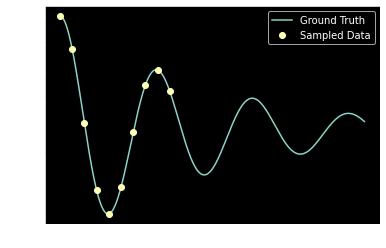

In [3]:
delta, omega = 2, 20
x = torch.linspace(0,1,500)
y = oscillator(delta, omega, x)


x_ground_truth = x[0:200:20]
y_ground_truth = y[0:200:20]

plt.plot(x, y)
plt.plot(x_ground_truth, y_ground_truth, 'o')
plt.legend(['Ground Truth', 'Sampled Data'])

In [4]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mu = nn.Parameter(torch.tensor([0.0]))
        
        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
        )
        
    def forward(self, x):
        return self.model(x)

In [5]:
EPOCHS = 20000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3

In [6]:
model = PINN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
MSE_LOSS = nn.MSELoss()

In [7]:
PDE_POINTS = 100

def PDE_loss():
    
    mu = model.mu
    k = omega**2
    
    t = torch.linspace(0,1, PDE_POINTS, requires_grad=True).view(-1,1).to(DEVICE)
    x = model(t).view(-1,1)
    
    x_t = derivative(x,t)
    x_tt = derivative(x_t,t)
    
    differatial_output = x_tt+mu*x_t+k*x
    
    loss = torch.mean(torch.square(differatial_output))
    
    return loss

Epoch: 1000	Overall Loss: 0.04132876545190811	PDE Loss: 0.03437964782714844


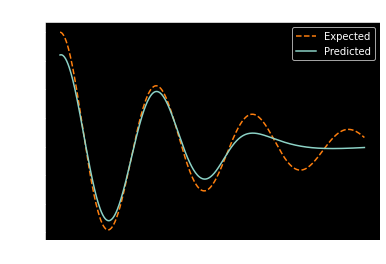

Epoch: 2000	Overall Loss: 0.017224354669451714	PDE Loss: 0.01575287628173828


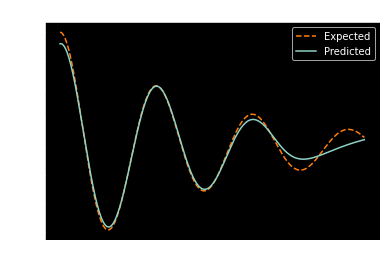

Epoch: 3000	Overall Loss: 0.010406814515590668	PDE Loss: 0.009962759399414062


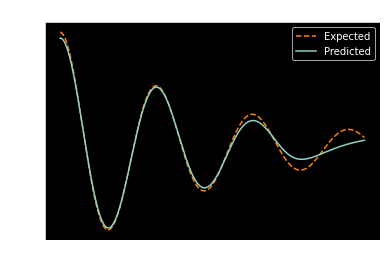

Epoch: 4000	Overall Loss: 0.006932151038199663	PDE Loss: 0.006700847625732422


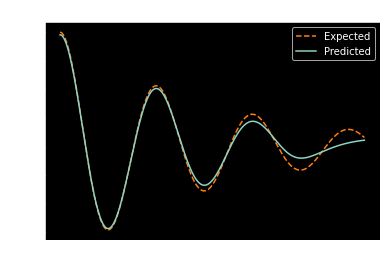

Epoch: 5000	Overall Loss: 0.004768436774611473	PDE Loss: 0.004459477615356445


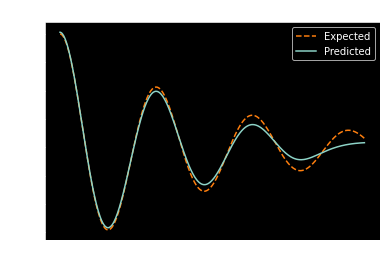

Epoch: 6000	Overall Loss: 0.0030421968549489975	PDE Loss: 0.0024838212966918948


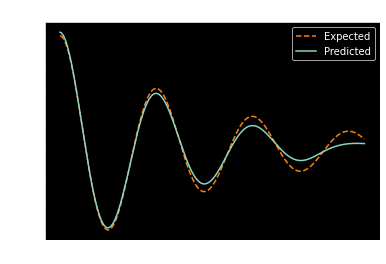

Epoch: 7000	Overall Loss: 0.0014240362215787172	PDE Loss: 0.0008497869491577149


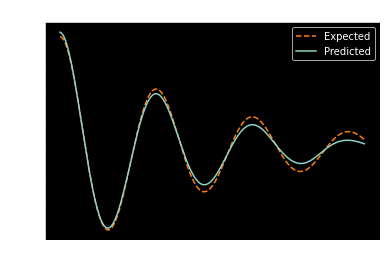

Epoch: 8000	Overall Loss: 0.00036346580600365996	PDE Loss: 0.00020536041259765626


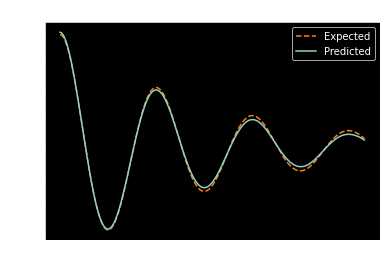

Epoch: 9000	Overall Loss: 0.00023337996390182525	PDE Loss: 0.00018751657009124758


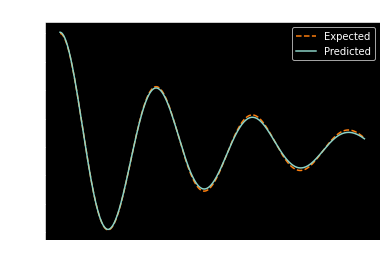

Epoch: 10000	Overall Loss: 0.00018583428754936904	PDE Loss: 0.0001673107147216797


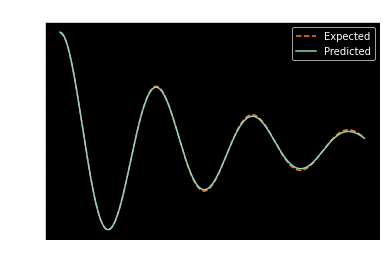

Epoch: 11000	Overall Loss: 0.00016701138520147651	PDE Loss: 0.00015266647338867188


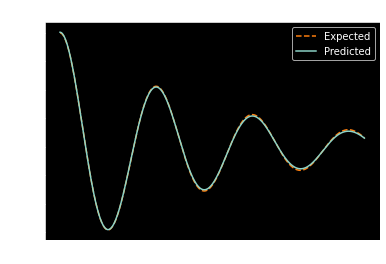

Epoch: 12000	Overall Loss: 0.0001508902496425435	PDE Loss: 0.00013928585052490236


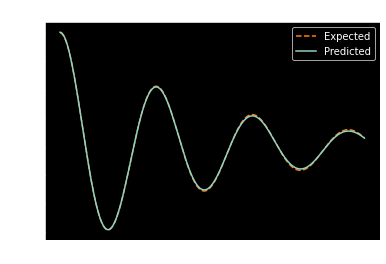

Epoch: 13000	Overall Loss: 0.00016868681996129453	PDE Loss: 0.0001539791226387024


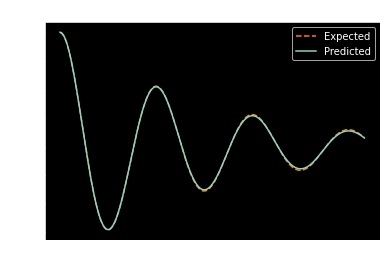

Epoch: 14000	Overall Loss: 0.00013928741100244224	PDE Loss: 0.00013179808855056762


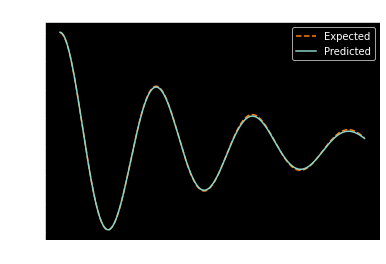

Epoch: 15000	Overall Loss: 0.0003879560681525618	PDE Loss: 0.0003435492753982544


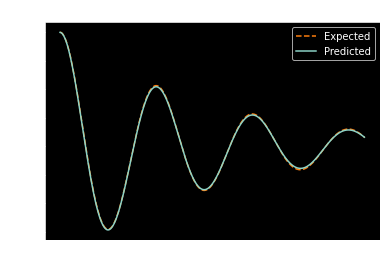

Epoch: 16000	Overall Loss: 0.00010816058056661859	PDE Loss: 0.00010008841753005982


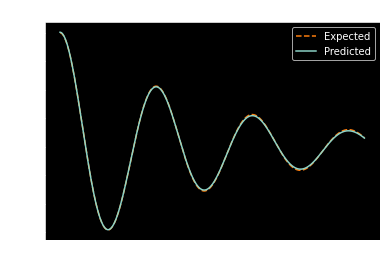

Epoch: 17000	Overall Loss: 9.862505248747766e-05	PDE Loss: 9.243899583816529e-05


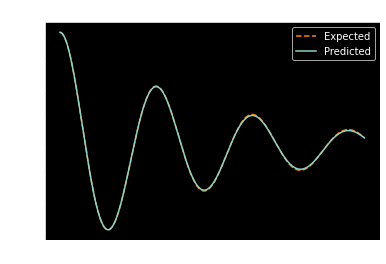

Epoch: 18000	Overall Loss: 0.00045897893141955137	PDE Loss: 0.0004543604373931885


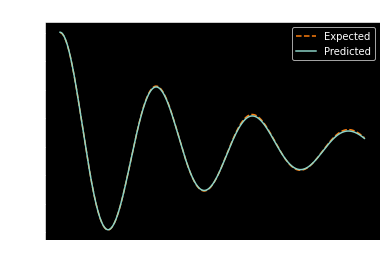

Epoch: 19000	Overall Loss: 0.000457783171441406	PDE Loss: 0.0004528804779052735


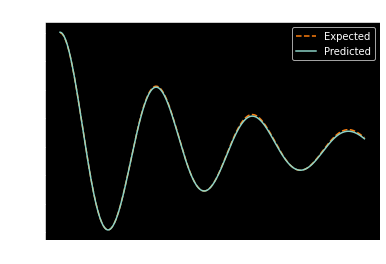

Epoch: 20000	Overall Loss: 0.00010532150918152183	PDE Loss: 0.00010097205638885498


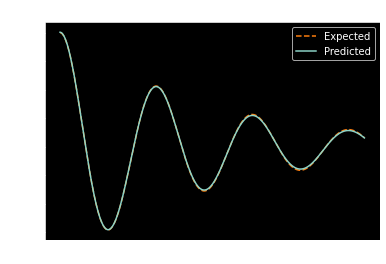

In [8]:
model.train()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    pde_loss = PDE_loss()
    
    ground_truth_loss =  MSE_LOSS(model(x_ground_truth.to(DEVICE).view(-1,1)), y_ground_truth.to(DEVICE).view(-1,1))
    
    loss = (1e-4)*pde_loss + ground_truth_loss
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        
        
        print(f"Epoch: {epoch+1}\tOverall Loss: {loss.item()}\tPDE Loss: {(1e-4)*pde_loss.item()}")
        
        test_x = torch.linspace(0, 1, 500).reshape(-1, 1)
        
        position = model(test_x.to(DEVICE)).detach()
        plt.plot(x, y, color='tab:orange', linestyle='--') # from second cell
        plt.plot(test_x.view(-1), position.cpu().view(-1), label='theta')
        plt.title(f'Epoch {epoch+1} -- Loss: {loss.item()}')
        plt.legend(["Expected", "Predicted"])
        plt.show()

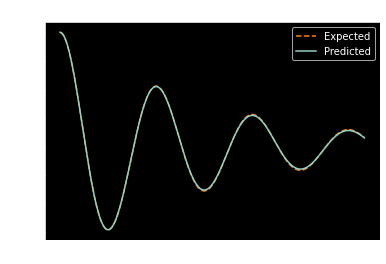

In [14]:
test_x = torch.linspace(0, 1, 500).reshape(-1, 1)
        
position = model(test_x.to(DEVICE)).detach()
plt.plot(x, y, color='tab:orange', linestyle='--') # from second cell
plt.plot(test_x.view(-1), position.cpu().view(-1), label='theta')
plt.title(f'Epoch {20000} -- Loss: {0.000105} -- Learned μ: {model.mu.item():.2f}')
plt.legend(["Expected", "Predicted"])
plt.show()